In [117]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [118]:
# path where resulting .csv files for cases and stringencies are stored
csv_filepath = os.path.abspath('')
csv_filepath

'/mnt/c/Users/user/PycharmProjects/covid-xprize-comp/ongoing/prescriptors'

In [119]:
# dictionary storing prescriptor files in format model_name: path_to_file
prescription_files = {
#     'NeatExample': 'covid_xprize/examples/prescriptors/neat/test_prescriptions/pres.csv',
#     'Random1': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_1.csv',
#     'Random2': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_2.csv',
#     'BlindGreedy': 'covid_xprize/examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv',
    'Greedy': os.path.join(csv_filepath, 'greedy_prescriptor_evaluate.csv'),
    'Greedy2': os.path.join(csv_filepath, 'greedy_prescriptor_evaluate2.csv')
}

In [120]:
def load_data(filepath):
    latest_df = pd.read_csv(filepath,
                            encoding="ISO-8859-1",
                            dtype={"RegionName": str},
                            error_bad_lines=False)
    return latest_df

In [121]:
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):    
    df = load_data(prescription_file)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)
df

,Unnamed: 0,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,TestName,PrescriptorName
0,0,Canada,NaN,0,24614.142819,3.000000,Fast_EC,Greedy
1,1,Canada,NaN,1,19550.980858,6.000000,Fast_EC,Greedy
2,2,Canada,NaN,2,19105.193093,8.000000,Fast_EC,Greedy
3,3,Canada,NaN,3,17999.052311,12.000000,Fast_EC,Greedy
4,4,Canada,NaN,4,17300.297770,14.000000,Fast_EC,Greedy
...,...,...,...,...,...,...,...,...
55,25,United States,Texas,5,26359.817570,6.139393,Fast_RC,Greedy2
56,26,United States,Texas,6,26048.195654,8.258654,Fast_RC,Greedy2
57,27,United States,Texas,7,25570.579876,12.898602,Fast_RC,Greedy2
58,28,United States,Texas,8,25235.034717,16.345018,Fast_RC,Greedy2


In [122]:
df[df['CountryName'] == 'Canada']

,Unnamed: 0,CountryName,RegionName,PrescriptionIndex,PredictedDailyNewCases,Stringency,TestName,PrescriptorName
0,0,Canada,NaN,0,24614.142819,3.000000,Fast_EC,Greedy
1,1,Canada,NaN,1,19550.980858,6.000000,Fast_EC,Greedy
2,2,Canada,NaN,2,19105.193093,8.000000,Fast_EC,Greedy
3,3,Canada,NaN,3,17999.052311,12.000000,Fast_EC,Greedy
4,4,Canada,NaN,4,17300.297770,14.000000,Fast_EC,Greedy
5,5,Canada,NaN,5,16860.524302,17.000000,Fast_EC,Greedy
6,6,Canada,NaN,6,16546.185319,19.000000,Fast_EC,Greedy
7,7,Canada,NaN,7,15993.843467,23.000000,Fast_EC,Greedy
8,8,Canada,NaN,8,15729.875139,25.000000,Fast_EC,Greedy
9,9,Canada,NaN,9,15319.421921,28.000000,Fast_EC,Greedy


In [123]:
# Compute domination relationship for each pair of prescriptors for each geo
def compute_domination_df(df):
    country_names = []
    region_names = []
    dominating_names = []
    dominated_names = []
    dominated_idxs = []
    prescriptor_names = sorted(df['PrescriptorName'].unique())  # Greedy, Greedy2
    prescription_idxs = sorted(df['PrescriptionIndex'].unique())  # 0-9
    for country_name in df['CountryName'].unique():
        cdf = df[df['CountryName'] == country_name]
        for region_name in cdf['RegionName'].unique():
            print('Computing domination for', country_name, region_name)
            if pd.isna(region_name):
                rdf = cdf[cdf['RegionName'].isna()]
            else:
                rdf = cdf[cdf['RegionName'] == region_name]
            for name1 in prescriptor_names:
                dominated_prescriptions = set() # To collect all dominated prescriptions
                                                # this is a set, so each dominated
                                                # prescription is only counted once per
                                                # submission.
                name1_df = rdf[rdf['PrescriptorName'] == name1]
                name1_idxs = sorted(name1_df['PrescriptionIndex'].unique())
                for i in name1_idxs:
                    idf = name1_df[name1_df['PrescriptionIndex'] == i]
                    i_cases = idf['PredictedDailyNewCases'].values[0]
                    i_stringency = idf['Stringency'].values[0]
                    
                    # Compare name1 to all other prescriptions
                    for name2 in prescriptor_names:
                        if name1 != name2:
                            name2_df = rdf[rdf['PrescriptorName'] == name2]
                            name2_idxs = sorted(name2_df['PrescriptionIndex'].unique())  
                            for j in name2_idxs:
                                jdf = name2_df[name2_df['PrescriptionIndex'] == j]
                                j_cases = jdf['PredictedDailyNewCases'].values[0]
                                j_stringency = jdf['Stringency'].values[0]
                                if (i_cases < j_cases) and (i_stringency < j_stringency):
                                    dominated_prescriptions.add((name2, j))
                for name2, j in dominated_prescriptions:
                    country_names.append(country_name)
                    region_names.append(region_name)
                    dominating_names.append(name1)
                    dominated_names.append(name2)
                    dominated_idxs.append(j)
    ddf = pd.DataFrame({
        'CountryName': country_names,
        'RegionName': region_names,
        'DominatingName': dominating_names,
        'DominatedName': dominated_names,
        'DominatedIndex': dominated_idxs})
    return ddf

In [124]:
ddf = compute_domination_df(df)


Computing domination for Canada nan
Computing domination for United States nan
Computing domination for United States Texas


In [125]:
# Get number of dominated prescriptions for each submission. This is the "Domination Count"
ddf.groupby('DominatingName').count().sort_values('DominatedIndex', ascending=False)['DominatedIndex']
ddf

,CountryName,RegionName,DominatingName,DominatedName,DominatedIndex


In [126]:
#
# Helpful functions for visualizing the area dominated by a set of solutions.
#

def compute_pareto_set(objective1_list, objective2_list):
    """
    Return objective values for the subset of solutions that
    lie on the pareto front.
    """
    
    assert len(objective1_list) == len(objective2_list), \
            "Each solution must have a value for each objective."
        
    n_solutions = len(objective1_list)
    
    objective1_pareto = []
    objective2_pareto = []
    for i in range(n_solutions):
        is_in_pareto_set = True
        for j in range(n_solutions):
            if (objective1_list[j] < objective1_list[i]) and \
                    (objective2_list[j] < objective2_list[i]):
                is_in_pareto_set = False
        if is_in_pareto_set:
            objective1_pareto.append(objective1_list[i])         
            objective2_pareto.append(objective2_list[i])   
    
    return objective1_pareto, objective2_pareto

    
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

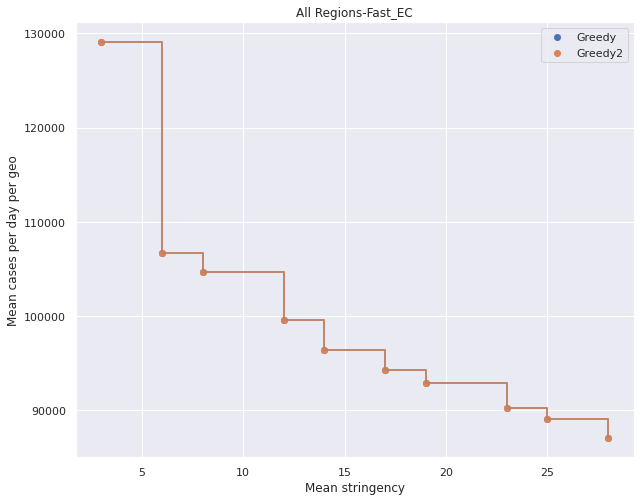

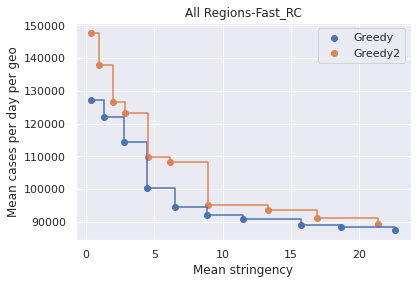

In [127]:
sns.set_theme()

# Plot overall stringency and cases of each prescription

plt.figure(figsize=(10,8))

for test in df['TestName'].unique():  # plot for each test 
    for prescriptor_name in prescription_files:
        pdf = df[df['PrescriptorName'] == prescriptor_name]
        pdf = pdf[pdf['TestName'] == test]
        overall_pdf = pdf.groupby(['PrescriptionIndex', ]).mean().reset_index()
        plt.scatter(overall_pdf['Stringency'],
                    overall_pdf['PredictedDailyNewCases'], 
                    label=prescriptor_name)
        plot_pareto_curve(list(overall_pdf['Stringency']),
                         list(overall_pdf['PredictedDailyNewCases']))
    plt.xlabel('Mean stringency')
    plt.ylabel('Mean cases per day per geo')
    plt.title('All Regions' + '-' + test)
    plt.legend()
    plt.show()

In [128]:
### Need to save prescriptions dataframe, `presc_df`, in evaluate method of prescriptors/base.py as .csv file 
### and load it in here as `submission_file` variable

# # Plot stacked line chart of npis over time for a prescription for a particular geo

# #submission_file = 'covid_xprize.examples/prescriptors/neat/test_prescriptions/pres.csv'
# submission_file = 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_1.csv'

# prescription_index = 2
# country_name = 'United States'
# region_name = None

# pdf = pd.read_csv(submission_file)
# gdf = pdf[(pdf['PrescriptionIndex'] == prescription_index) &
#           (pdf['CountryName'] == country_name) &
#           (pdf['RegionName'].isna() if region_name is None else (pdf['RegionName'] == 'region_name'))]
# gdf.plot.area(x='Date', y=NPI_COLS, figsize=(10,8), ylabel='Stringency')

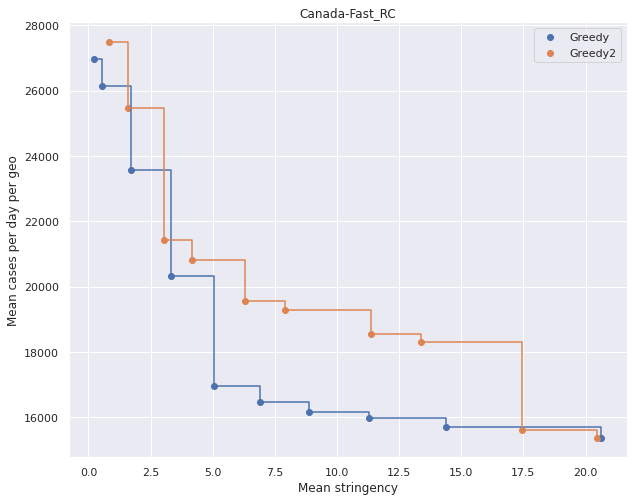

In [129]:
# Plot stringency and cases of each prescription for a particular country and specific test

country_name = 'Canada'
test = 'Fast_RC'  # options: FasT_RC, FasT_EC

cdf = df[df.CountryName == country_name]
cdf = cdf[cdf['TestName'] == test]

plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = cdf[cdf['PrescriptorName'] == prescriptor_name]
    plt.scatter(pdf['Stringency'],
                pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(pdf['Stringency']),
                      list(pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.title(country_name + '-' + test)
plt.legend()
plt.show()
